In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import CSVLoggerCallback

# Preprocessing the data

In [2]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 128

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [3]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [4]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [5]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to augmented training data
train_data_augmented = train_data_augmented.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True,  
    verbose=1  
)

# Feature extraction model

In [13]:
from tensorflow.keras import layers, Model, regularizers

#import the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

# congelo il modello base, così che i pattern imparati rimangano
base_model.trainable = False

inputs = tf.keras.Input((128,128,3), name='inputs') 
# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
#average pooling 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
#outputs
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

feature_extraction_model = tf.keras.Model(inputs = inputs, outputs = outputs)

#compile the model
feature_extraction_model.compile(
                                optimizer = tf.keras.optimizers.Adam(), 
                                loss = tf.keras.losses.categorical_crossentropy,
                                metrics = ['accuracy']
)


52606240/52606240 [==============================] - 58s 1us/step


In [15]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_cnn = feature_extraction_model.fit(
                                            train_data_augmented,
                                            epochs=3,
                                            validation_data=valid_data,
                                            validation_steps=len(valid_data),
                                            callbacks=[CSVLoggerCallback('results.csv','efficientnet_B6')]
)

Epoch 1/3
746/746 [==============================] - 394s 527ms/step - loss: 1.6571 - accuracy: 0.3565 - val_loss: 1.9129 - val_accuracy: 0.2537
Epoch 2/3
746/746 [==============================] - 431s 577ms/step - loss: 1.6397 - accuracy: 0.3653 - val_loss: 1.9124 - val_accuracy: 0.2557
Epoch 3/3
746/746 [==============================] - 400s 535ms/step - loss: 1.6155 - accuracy: 0.3752 - val_loss: 1.9326 - val_accuracy: 0.2581


In [ ]:
feature_extraction_model.save('efficientnet_B6_feat_extr.h5')

# Evaluate the model

In [16]:
feature_extraction_model.evaluate(test_data)

64/64 [==============================] - 34s 534ms/step - loss: 1.9436 - accuracy: 0.2552


[1.94364595413208, 0.25517240166664124]

## Confusion matrix

In [18]:
from helper_functions import plot_confusion_matrix

# Create test labels and predictions
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(tf.argmax(labels).numpy())
test_pred_probs = feature_extraction_model.predict(test_data)
test_predictions = tf.argmax(test_pred_probs, axis=1)

64/64 [==============================] - 36s 512ms/step


array([[0.44827586, 0.05862069, 0.11034483, 0.04482759, 0.16896552,
        0.04482759, 0.12413793],
       [0.20344828, 0.24827586, 0.16896552, 0.05172414, 0.07241379,
        0.06551724, 0.18965517],
       [0.1862069 , 0.05172414, 0.24137931, 0.04482759, 0.2       ,
        0.17241379, 0.10344828],
       [0.20689655, 0.09655172, 0.12413793, 0.07241379, 0.18965517,
        0.13103448, 0.17931034],
       [0.18965517, 0.05517241, 0.11034483, 0.0862069 , 0.27241379,
        0.13448276, 0.15172414],
       [0.1137931 , 0.05172414, 0.14482759, 0.03448276, 0.37241379,
        0.13448276, 0.14827586],
       [0.1       , 0.0862069 , 0.07586207, 0.06896552, 0.18275862,
        0.11724138, 0.36896552]])

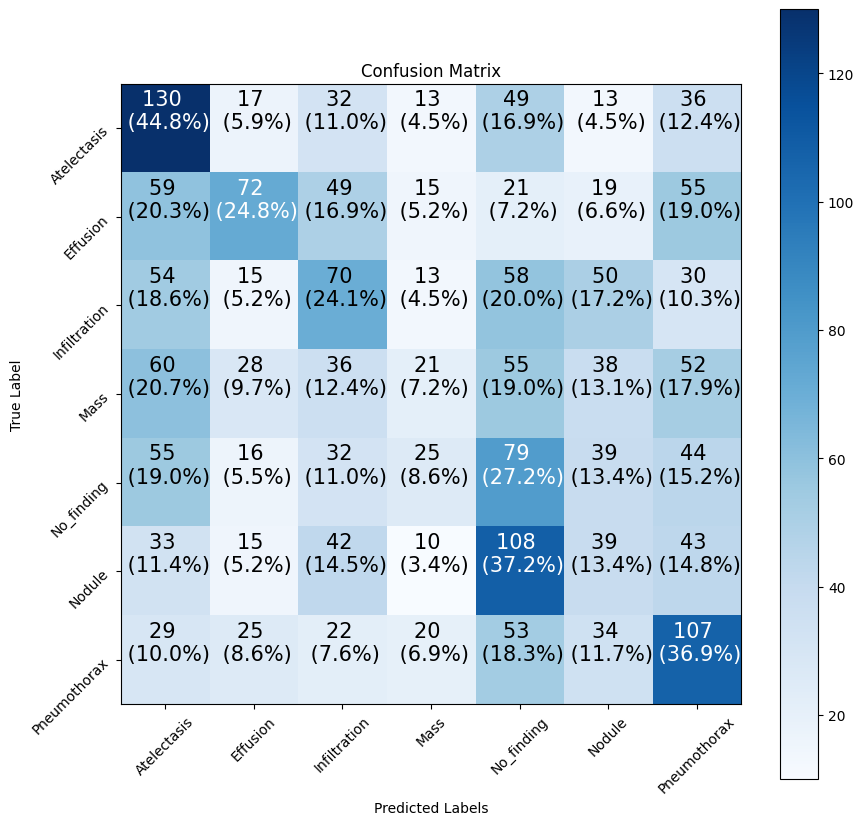

In [19]:
plot_confusion_matrix(test_labels, test_predictions, class_names)